In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
import numba
from numba import jit

$$ru\left(1-\frac{u}{K}\right) - hu + D\nabla^2 u = \frac{\partial u}{\partial t}$$

$$ru_{i,j}^{(m)} \left(1 - \frac{u_{i,j}^{(m)}}{K} \right) - hu_{i,j}^{(m)} + D \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

$$(r-h)u_{i,j}^{(m)} - \frac{r(u_{i,j}^{(m)})^2}{K} + D \left( \frac{u_{i+1,j}^{(m)} -2u_{i,j}^{(m)} + u_{i-1,j}^{(m)}}{\Delta x^2} + \frac{u_{i,j+1}^{(m)} -2u_{i,j}^{(m)} + u_{i,j-1}^{(m)}}{\Delta y^2}\right) = \frac{u_j^{(m+1)} - u_j^{(m)}}{\Delta t} $$ 

Can rearrange to solve for $m+1$ 

$$ u_j^{(m+1)} = u_j^{(m)} + \Delta t\left[(r-h)u_{i,j}^{(m)} - \frac{r(u_{i,j}^{(m)})^2}{K} + \frac{D}{\Delta x^2} \left( u_{i+1,j}^{(m)} + u_{i-1,j}^{(m)} +  u_{i,j+1}^{(m)} + u_{i,j-1}^{(m)}  -4u_{i,j}^{(m)} \right)\right] $$

Initialise space grid with random spawns

In [3]:
n = 100
i = 5
# coords = np.array([(np.random.randint(i, n-i), np.random.randint(i, n-i)) for _ in range (50)])
# for x, y in coords:
init_population = np.zeros((n, n))
init_population[:,0] = 80

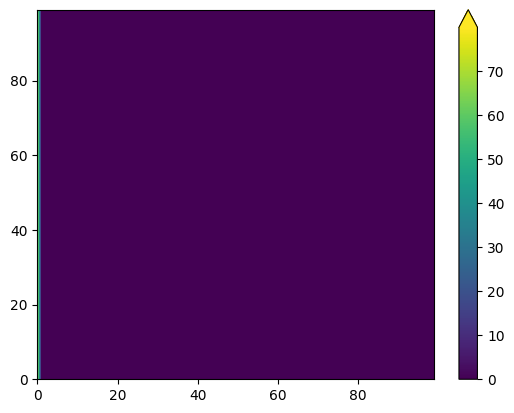

In [4]:
fig,ax = plt.subplots()
vmin,vmax = int(np.min(init_population)), int(np.max(init_population))
contourf_ = ax.contourf(init_population, levels=np.linspace(vmin,vmax,400),extend='max')
cbar = fig.colorbar(contourf_,ticks=range(vmin, vmax, 10))

diffusion constant

In [5]:
D = 0.27 # mm^2/sec
# D *= 0.01
# D # cm^2/sec

Set the dimensions of the problem

In [6]:
x = 5
dx = 0.05
dt = 0.001

In [6]:
total_time = 3600*24 # sec
times = int(total_time/dt)
times_snapshot = 60*24
f = int(times/times_snapshot)
population_frames = np.zeros([times_snapshot, 100, 100])
population_frames[0] = init_population
population_size = np.zeros(times)

* Number of differential equation update iterations `times`
* Number of snapshots we will take `times_snaphot`. 
* The array of snapshots we will take of the turkey


In [7]:
print(f'Snapshot taken every {f}th frame.')
print(f'Total time of simulation is {times*dt} sec.')
print(f'Snapshot taken every {f*dt} sec.')

Snapshot taken every 60000th frame.
Total time of simulation is 86400.0 sec.
Snapshot taken every 60.0 sec.


Compute $s = \alpha \Delta t / \Delta x^2$. $s$ needs to be much less than 1/4 for this to work.

In [8]:
D * dt / dx**2

0.10799999999999998

Set up numba function

In [ ]:
@numba.jit("(f8[:,:,:], f8, f8, f8)", nopython=True, nogil=True, fastmath = True)
def solve_heat(environment, K, r, h):
    cs = environment[0].copy() #current state
    length = len(cs[0])
    size = np.zeros(times)
    size[0] = np.average(cs)
    cf = 0 # current frame
    for t in range(1, times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                ns[j][i] = cs[j][i] + D*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i]) +\
                                                    dt*((r-h)*cs[j][i] - (r*cs[j][i]**2)/K)
                                                    # dt*(r*cs[j][i]*(1-(cs[j][i]/K)) - (h*cs[j][i]))
        size[t] = np.average(cs)
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            environment[cf] = cs
            
    if t/(times/10)%1 == 0:
        print(f'{int(t/(times/10))*10}% done') 
    return environment, size

Get population snapshots and population size over time plot

In [ ]:
K, r, h = 1, 0.9, 0.2
population_frames, population_sizes = solve_heat(population_frames, K, r, h)
plt.plot(np.linspace(0, times*dt, times), population_sizes/1e4)
plt.xlabel('Time (s)')
plt.ylabel('Total Population')

The final snapshot

In [7]:
my_cmap = plt.get_cmap('inferno')
plt.figure(figsize=(8,8))
a = plt.contourf(population_frames[-1], 100, cmap=my_cmap)
plt.colorbar(a)

NameError: name 'population_frames' is not defined

<Figure size 800x800 with 0 Axes>

Make animation

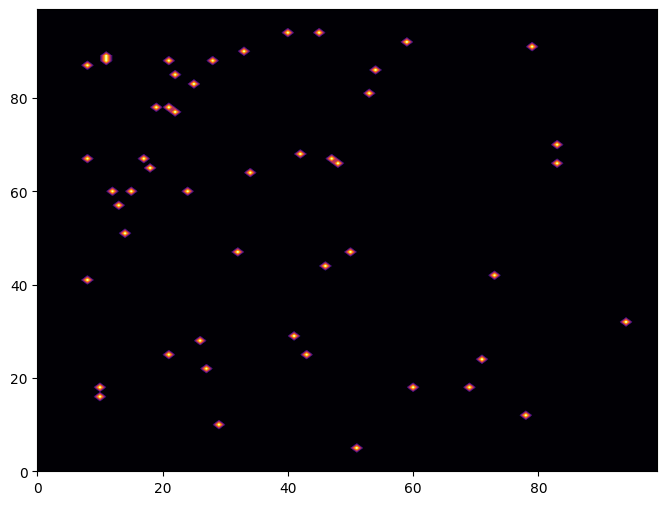

In [31]:
def animate(i):
    ax.clear()
    ax.contourf(population_frames[10*i], 100, cmap=my_cmap) #put vmin and vmax

    return fig,

fig, ax = plt.subplots(figsize=(8,6))
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('population1.gif',writer='pillow',fps=30)